# 🔧 Feature Engineering 최종 결과 - OHJ

**분석자**: 오흥재 (vfxpedia)  
**작성일**: 2025-10-14 (최종 업데이트)  
**목적**: 교육 및 경제활동 관련 Feature Engineering 최종 검증

---

## 📋 분석 개요

### 📌 목표
1. **5개 파생변수** 최종 검증 및 수치화
2. **Before/After 비교**를 통한 개선 효과 시각화
3. 금연 성공률과의 **상관관계 분석**
4. 모델 학습 준비 완료

### 🎯 최종 Feature Engineering (5개)

| 번호 | 원본 변수 | 새 변수 | 변환 | 불균형 | 성공률 차이 | 근거 |
|------|----------|---------|------|--------|------------|------|
| 1 | sob_01z1 (10개) | `education_group` | 3그룹 | 51.62:1 ❌ | 17.0%p | EDA 06: 역U자 패턴 |
| 2 | soa_01z1 (4개) | `is_economically_active` | Binary | 2.59:1 ✅ | 13.7%p | EDA 07: 직장 스트레스 |
| 3 | soa_06z2 (13개) | `occupation_type` | 3그룹 | 2.50:1 ✅ | 14.6%p | EDA 07: 직업 환경 |
| 4 | soa_07z1 (6개) | `is_employee` | Binary | 2.59:1 ✅ | 13.7%p | EDA 07: 고용 형태 |
| 5 | sod_02z3 (7개) | `marital_stability` | 3그룹 | 18.72:1 ⚠️ | 21.9%p | 사회적 지지 |

### 🔄 변경 이력
- ~~`job_risk_group`~~ → `occupation_type` 변경 (일관성)
- ~~`is_married`~~ → 제거 (`marital_stability`가 더 디테일)
- 한글 → 영어 (white_color, stable 등)
- 불균형 해소 (기타 카테고리 통합)

### 📊 기대 효과
- ✅ **단순화**: 평균 7개 → 3개 카테고리 (57% 감소)
- ✅ **예측력**: 평균 16%p 금연 성공률 차이
- ✅ **불균형 완화**: 기타 카테고리 통합으로 극단적 불균형 해소


## 1️⃣ 환경 설정


In [7]:
# 라이브러리 임포트
import sys
import os

# 프로젝트 루트를 Python 경로에 추가
project_root = os.path.abspath('../../..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Variable Decoder
from notebooks.vfxpedia.utils.variable_decoder import (
    VariableDecoder,
    get_korean_label
)

# Feature Engineering 모듈
from notebooks.vfxpedia.utils.feature_engineering import (
    apply_feature_engineering,
    print_feature_info,
    FEATURE_DESCRIPTIONS
)

# 시각화 설정
import matplotlib.font_manager as fm
try:
    font_path = "C:/Windows/Fonts/HMFMMUEX.TTC"
    if os.path.exists(font_path):
        font_prop = fm.FontProperties(fname=font_path)
        plt.rcParams['font.family'] = font_prop.get_name()
    else:
        plt.rcParams['font.family'] = 'Malgun Gothic'
except:
    plt.rcParams['font.family'] = 'Malgun Gothic'

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (14, 6)

# 팀 컬러
TEAM_COLORS = {
    'primary': '#1f77b4',
    'success': '#ff7f0e',
    'palette': ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
}

print("✅ 모든 라이브러리 로드 완료")


✅ 모든 라이브러리 로드 완료


## 2️⃣ 데이터 로드


In [8]:
# 정제된 데이터 로드
DATA_PATH = '../../../data/analy_data.csv'  # 최종 데이터 경로
df = pd.read_csv(DATA_PATH)

print("=" * 70)
print("📊 데이터 기본 정보")
print("=" * 70)
print(f"데이터 크기: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\n🎯 타겟 변수 (churn) 분포:")
print(df['churn'].value_counts())
print(f"\n금연 성공률: {df['churn'].mean() * 100:.2f}%")

# Feature Engineering 대상 변수 확인
target_vars = ['sob_01z1', 'soa_01z1', 'soa_06z2', 'soa_07z1', 'sod_02z3']

print(f"\n✅ Feature Engineering 대상 원본 변수 ({len(target_vars)}개):")
for var in target_vars:
    missing = df[var].isna().sum()
    pct = missing / len(df) * 100
    unique = df[var].nunique()
    print(f"   {var}: {unique}개 카테고리, 결측값 {missing:,}개 ({pct:.1f}%)")


📊 데이터 기본 정보
데이터 크기: 89,822 rows × 210 columns

🎯 타겟 변수 (churn) 분포:
churn
1    49251
0    40571
Name: count, dtype: int64

금연 성공률: 54.83%

✅ Feature Engineering 대상 원본 변수 (5개):
   sob_01z1: 10개 카테고리, 결측값 0개 (0.0%)
   soa_01z1: 4개 카테고리, 결측값 0개 (0.0%)
   soa_06z2: 13개 카테고리, 결측값 0개 (0.0%)
   soa_07z1: 6개 카테고리, 결측값 0개 (0.0%)
   sod_02z3: 7개 카테고리, 결측값 0개 (0.0%)


---
## 3️⃣ Feature Engineering 함수 정의


In [9]:
# 1. education_group
def feature_education_group(df_merge):
    conditions = [
        df_merge['sob_01z1'] <= 2,
        df_merge['sob_01z1'] == 3,
        df_merge['sob_01z1'] >= 4
    ]
    choices = [0, 1, 2]
    df_merge['education_group'] = np.select(conditions, choices, default=np.nan)
    return df_merge

# 2. is_economically_active
def feature_is_economically_active(df_merge):
    df_merge['is_economically_active'] = np.where(
        df_merge['soa_01z1'] == 1, 1, 0
    )
    return df_merge

# 3. occupation_type
def feature_occupation_type(df_merge):
    conditions = [
        df_merge['soa_06z2'].isin([1, 2, 3]),
        df_merge['soa_06z2'] == 88
    ]
    choices = ['white_color', 'inactive']
    df_merge['occupation_type'] = np.select(conditions, choices, default='blue_color')
    return df_merge

# 4. is_employee
def feature_is_employee(df_merge):
    df_merge['is_employee'] = np.where(
        df_merge['soa_07z1'].isin([1, 2, 3]), 1, 0
    )
    return df_merge

# 5. marital_stability
def feature_marital_stability(df_merge):
    conditions = [
        df_merge['sod_02z3'] == 1,
        df_merge['sod_02z3'] == 2
    ]
    choices = ['stable', 'single']
    df_merge['marital_stability'] = np.select(conditions, choices, default='unstable')
    return df_merge

# Feature 생성 적용
print("🔧 Feature Engineering 시작...")
df = feature_education_group(df)
df = feature_is_economically_active(df)
df = feature_occupation_type(df)
df = feature_is_employee(df)
df = feature_marital_stability(df)

# 생성 확인
new_features = ['education_group', 'is_economically_active', 'occupation_type', 
                'is_employee', 'marital_stability']

print(f"\n✅ Feature Engineering 완료!")
for feat in new_features:
    count = df[feat].notna().sum()
    unique = df[feat].nunique()
    print(f"   {feat}: {count:,}개 생성 ({unique}개 카테고리)")

print(f"\n📊 최종 데이터 shape: {df.shape}")


🔧 Feature Engineering 시작...

✅ Feature Engineering 완료!
   education_group: 89,822개 생성 (3개 카테고리)
   is_economically_active: 89,822개 생성 (2개 카테고리)
   occupation_type: 89,822개 생성 (3개 카테고리)
   is_employee: 89,822개 생성 (2개 카테고리)
   marital_stability: 89,822개 생성 (3개 카테고리)

📊 최종 데이터 shape: (89822, 215)


In [10]:
print("=" * 70)
print("📊 생성된 5개 Feature 요약")
print("=" * 70)

feature_summary = {
    'education_group': '교육수준 (0:저/1:중/2:고)',
    'is_economically_active': '경제활동 여부 (0:비활동/1:활동)',
    'occupation_type': '직업 유형 (white_color/blue_color/inactive)',
    'is_employee': '임금근로자 여부 (0:비임금/1:임금)',
    'marital_stability': '혼인 안정성 (stable/single/unstable)'
}

for i, (feat, desc) in enumerate(feature_summary.items(), 1):
    print(f"\n{i}. {feat}")
    print(f"   설명: {desc}")
    print(f"   분포: {df[feat].value_counts().to_dict()}")

print("\n" + "=" * 70)


📊 생성된 5개 Feature 요약

1. education_group
   설명: 교육수준 (0:저/1:중/2:고)
   분포: {2.0: 78406, 1.0: 9897, 0.0: 1519}

2. is_economically_active
   설명: 경제활동 여부 (0:비활동/1:활동)
   분포: {1: 64823, 0: 24999}

3. occupation_type
   설명: 직업 유형 (white_color/blue_color/inactive)
   분포: {'blue_color': 46306, 'inactive': 24995, 'white_color': 18521}

4. is_employee
   설명: 임금근로자 여부 (0:비임금/1:임금)
   분포: {1: 64814, 0: 25008}

5. marital_stability
   설명: 혼인 안정성 (stable/single/unstable)
   분포: {'stable': 59608, 'unstable': 27030, 'single': 3184}



---
## 4️⃣ Feature별 Before/After 비교 분석


### 📊 Feature 1: education_group (교육수준)


In [11]:
print("=" * 70)
print("📌 Feature 1: education_group (교육수준)")
print("=" * 70)

# Before: sob_01z1 원본 분석
print("\n🔴 BEFORE: sob_01z1 (원본)")
print(f"   카테고리 수: {df['sob_01z1'].nunique()}개")
print(f"   분포:")
orig_dist = df['sob_01z1'].value_counts().sort_index()
for code, count in orig_dist.items():
    pct = count / len(df) * 100
    success_rate = df[df['sob_01z1']==code]['churn'].mean() * 100
    print(f"      {int(code)}: {count:,}명 ({pct:.1f}%) - 성공률 {success_rate:.1f}%")

# After: education_group 파생 분석
print("\n🟢 AFTER: education_group (파생)")
print(f"   카테고리 수: {df['education_group'].nunique()}개")
print(f"   분포:")
group_labels = {0: '저학력', 1: '중학력', 2: '고학력'}
new_dist = df['education_group'].value_counts().sort_index()
for code, count in new_dist.items():
    pct = count / len(df) * 100
    success_rate = df[df['education_group']==code]['churn'].mean() * 100
    label = group_labels[int(code)]
    print(f"      {int(code)} ({label}): {count:,}명 ({pct:.1f}%) - 성공률 {success_rate:.2f}%")

# 불균형 비율
max_count = new_dist.max()
min_count = new_dist.min()
imbalance = max_count / min_count
print(f"\n📈 불균형 비율: {imbalance:.2f}:1")

# 성공률 차이
max_rate = df.groupby('education_group')['churn'].mean().max() * 100
min_rate = df.groupby('education_group')['churn'].mean().min() * 100
print(f"📊 성공률 차이: {max_rate - min_rate:.2f}%p")

print("\n✅ 개선 효과:")
print(f"   카테고리 수: {df['sob_01z1'].nunique()}개 → {df['education_group'].nunique()}개")
print(f"   단순화: {(1 - df['education_group'].nunique()/df['sob_01z1'].nunique())*100:.0f}% 감소")
print("=" * 70)


📌 Feature 1: education_group (교육수준)

🔴 BEFORE: sob_01z1 (원본)
   카테고리 수: 10개
   분포:
      1: 1,465명 (1.6%) - 성공률 69.4%
      2: 54명 (0.1%) - 성공률 77.8%
      3: 9,897명 (11.0%) - 성공률 70.0%


      4: 10,378명 (11.6%) - 성공률 63.1%
      5: 31,369명 (34.9%) - 성공률 49.3%
      6: 11,171명 (12.4%) - 성공률 45.8%
      7: 21,721명 (24.2%) - 성공률 53.5%
      8: 3,733명 (4.2%) - 성공률 67.3%
      77: 33명 (0.0%) - 성공률 63.6%
      99: 1명 (0.0%) - 성공률 0.0%

🟢 AFTER: education_group (파생)
   카테고리 수: 3개
   분포:
      0 (저학력): 1,519명 (1.7%) - 성공률 69.65%
      1 (중학력): 9,897명 (11.0%) - 성공률 70.00%
      2 (고학력): 78,406명 (87.3%) - 성공률 52.63%

📈 불균형 비율: 51.62:1
📊 성공률 차이: 17.37%p

✅ 개선 효과:
   카테고리 수: 10개 → 3개
   단순화: 70% 감소


### 📊 Feature 2: is_economically_active (경제활동)


In [12]:
print("=" * 70)
print("📌 Feature 2: is_economically_active (경제활동 여부)")
print("=" * 70)

# Before: soa_01z1 원본
print("\n🔴 BEFORE: soa_01z1 (원본)")
print(f"   카테고리 수: {df['soa_01z1'].nunique()}개")
orig_dist = df['soa_01z1'].value_counts().sort_index()
for code, count in orig_dist.items():
    pct = count / len(df) * 100
    success_rate = df[df['soa_01z1']==code]['churn'].mean() * 100
    print(f"      {int(code)}: {count:,}명 ({pct:.1f}%) - 성공률 {success_rate:.2f}%")

# After: is_economically_active
print("\n🟢 AFTER: is_economically_active (파생)")
print(f"   카테고리 수: {df['is_economically_active'].nunique()}개")
labels = {0: '비경제활동', 1: '경제활동'}
new_dist = df['is_economically_active'].value_counts().sort_index()
for code, count in new_dist.items():
    pct = count / len(df) * 100
    success_rate = df[df['is_economically_active']==code]['churn'].mean() * 100
    print(f"      {code} ({labels[code]}): {count:,}명 ({pct:.1f}%) - 성공률 {success_rate:.2f}%")

# 개선 효과
max_count = new_dist.max()
min_count = new_dist.min()
print(f"\n📈 불균형 비율: {max_count/min_count:.2f}:1 ✅ (양호)")

rate_0 = df[df['is_economically_active']==0]['churn'].mean() * 100
rate_1 = df[df['is_economically_active']==1]['churn'].mean() * 100
print(f"📊 성공률 차이: {abs(rate_0-rate_1):.2f}%p")
print("\n✅ 핵심: 직장 스트레스가 금연 실패의 주요 원인")
print("=" * 70)


📌 Feature 2: is_economically_active (경제활동 여부)

🔴 BEFORE: soa_01z1 (원본)
   카테고리 수: 4개
      1: 64,823명 (72.2%) - 성공률 51.01%
      2: 24,995명 (27.8%) - 성공률 64.74%
      7: 1명 (0.0%) - 성공률 100.00%
      9: 3명 (0.0%) - 성공률 0.00%

🟢 AFTER: is_economically_active (파생)
   카테고리 수: 2개
      0 (비경제활동): 24,999명 (27.8%) - 성공률 64.74%
      1 (경제활동): 64,823명 (72.2%) - 성공률 51.01%

📈 불균형 비율: 2.59:1 ✅ (양호)
📊 성공률 차이: 13.73%p

✅ 핵심: 직장 스트레스가 금연 실패의 주요 원인


### 📊 Feature 3: occupation_type (직업 유형)


In [13]:
print("=" * 70)
print("📌 Feature 3: occupation_type (직업 유형)")
print("=" * 70)

# Before: soa_06z2 원본
print("\n🔴 BEFORE: soa_06z2 (원본)")
print(f"   카테고리 수: {df['soa_06z2'].nunique()}개")
orig_dist = df['soa_06z2'].value_counts().sort_index()
print(f"   분포: (주요 카테고리만)")
for code, count in list(orig_dist.items())[:5]:
    pct = count / len(df) * 100
    success_rate = df[df['soa_06z2']==code]['churn'].mean() * 100
    print(f"      {int(code)}: {count:,}명 ({pct:.1f}%) - 성공률 {success_rate:.2f}%")
print(f"      ... (총 {df['soa_06z2'].nunique()}개)")

# After: occupation_type
print("\n🟢 AFTER: occupation_type (파생)")
print(f"   카테고리 수: {df['occupation_type'].nunique()}개")
new_dist = df['occupation_type'].value_counts()
for label, count in new_dist.items():
    pct = count / len(df) * 100
    success_rate = df[df['occupation_type']==label]['churn'].mean() * 100
    print(f"      {label}: {count:,}명 ({pct:.1f}%) - 성공률 {success_rate:.2f}%")

# 개선 효과
max_count = new_dist.max()
min_count = new_dist.min()
print(f"\n📈 불균형 비율: {max_count/min_count:.2f}:1 ✅ (양호)")
print(f"📊 카테고리 단순화: {df['soa_06z2'].nunique()}개 → {df['occupation_type'].nunique()}개")
print("\n✅ 핵심: 블루칼라 근로 환경이 금연에 불리")
print("=" * 70)


📌 Feature 3: occupation_type (직업 유형)

🔴 BEFORE: soa_06z2 (원본)
   카테고리 수: 13개
   분포: (주요 카테고리만)
      1: 2,282명 (2.5%) - 성공률 52.89%
      2: 7,773명 (8.7%) - 성공률 55.55%
      3: 8,466명 (9.4%) - 성공률 51.05%
      4: 5,800명 (6.5%) - 성공률 44.53%
      5: 4,607명 (5.1%) - 성공률 46.30%
      ... (총 13개)

🟢 AFTER: occupation_type (파생)
   카테고리 수: 3개
      blue_color: 46,306명 (51.6%) - 성공률 50.15%
      inactive: 24,995명 (27.8%) - 성공률 64.74%
      white_color: 18,521명 (20.6%) - 성공률 53.17%

📈 불균형 비율: 2.50:1 ✅ (양호)
📊 카테고리 단순화: 13개 → 3개

✅ 핵심: 블루칼라 근로 환경이 금연에 불리


### 📊 Feature 4: is_employee (임금근로자)


In [14]:
print("=" * 70)
print("📌 Feature 4: is_employee (임금근로자 여부)")
print("=" * 70)

# Before: soa_07z1 원본
print("\n🔴 BEFORE: soa_07z1 (원본)")
print(f"   카테고리 수: {df['soa_07z1'].nunique()}개")
orig_dist = df['soa_07z1'].value_counts().sort_index()
for code, count in orig_dist.items():
    pct = count / len(df) * 100
    success_rate = df[df['soa_07z1']==code]['churn'].mean() * 100
    print(f"      {int(code)}: {count:,}명 ({pct:.1f}%) - 성공률 {success_rate:.2f}%")

# After: is_employee
print("\n🟢 AFTER: is_employee (파생)")
print(f"   카테고리 수: {df['is_employee'].nunique()}개")
labels = {0: '비임금근로자', 1: '임금근로자'}
new_dist = df['is_employee'].value_counts().sort_index()
for code, count in new_dist.items():
    pct = count / len(df) * 100
    success_rate = df[df['is_employee']==code]['churn'].mean() * 100
    print(f"      {code} ({labels[code]}): {count:,}명 ({pct:.1f}%) - 성공률 {success_rate:.2f}%")

# 개선 효과
max_count = new_dist.max()
min_count = new_dist.min()
print(f"\n📈 불균형 비율: {max_count/min_count:.2f}:1 ✅ (양호)")

rate_0 = df[df['is_employee']==0]['churn'].mean() * 100
rate_1 = df[df['is_employee']==1]['churn'].mean() * 100
print(f"📊 성공률 차이: {abs(rate_0-rate_1):.2f}%p")
print("\n✅ 핵심: 임금근로자의 회식 문화, 스트레스")
print("=" * 70)


📌 Feature 4: is_employee (임금근로자 여부)

🔴 BEFORE: soa_07z1 (원본)
   카테고리 수: 6개
      1: 23,152명 (25.8%) - 성공률 55.67%
      2: 40,550명 (45.1%) - 성공률 48.23%
      3: 1,112명 (1.2%) - 성공률 55.58%
      7: 9명 (0.0%) - 성공률 33.33%
      8: 24,995명 (27.8%) - 성공률 64.74%
      9: 4명 (0.0%) - 성공률 25.00%

🟢 AFTER: is_employee (파생)
   카테고리 수: 2개
      0 (비임금근로자): 25,008명 (27.8%) - 성공률 64.73%
      1 (임금근로자): 64,814명 (72.2%) - 성공률 51.01%

📈 불균형 비율: 2.59:1 ✅ (양호)
📊 성공률 차이: 13.71%p

✅ 핵심: 임금근로자의 회식 문화, 스트레스


### 📊 Feature 5: marital_stability (혼인 안정성)


In [15]:
print("=" * 70)
print("📌 Feature 5: marital_stability (혼인 안정성)")
print("=" * 70)

# Before: sod_02z3 원본
print("\n🔴 BEFORE: sod_02z3 (원본)")
print(f"   카테고리 수: {df['sod_02z3'].nunique()}개")
orig_dist = df['sod_02z3'].value_counts().sort_index()
for code, count in orig_dist.items():
    pct = count / len(df) * 100
    success_rate = df[df['sod_02z3']==code]['churn'].mean() * 100
    print(f"      {int(code)}: {count:,}명 ({pct:.1f}%) - 성공률 {success_rate:.2f}%")

# After: marital_stability
print("\n🟢 AFTER: marital_stability (파생)")
print(f"   카테고리 수: {df['marital_stability'].nunique()}개")
new_dist = df['marital_stability'].value_counts()
for label, count in new_dist.items():
    pct = count / len(df) * 100
    success_rate = df[df['marital_stability']==label]['churn'].mean() * 100
    print(f"      {label}: {count:,}명 ({pct:.1f}%) - 성공률 {success_rate:.2f}%")

# 개선 효과
max_count = new_dist.max()
min_count = new_dist.min()
imbalance = max_count / min_count
print(f"\n📈 불균형 비율: {imbalance:.2f}:1")
print(f"   (Before: 무응답 17명으로 3506:1 → After: unstable 통합으로 {imbalance:.2f}:1)")

churn_by_group = df.groupby('marital_stability')['churn'].mean() * 100
max_rate = churn_by_group.max()
min_rate = churn_by_group.min()
print(f"📊 성공률 차이: {max_rate - min_rate:.2f}%p (최대)")
print("\n✅ 핵심: 배우자 이별(사별/이혼/별거) → 정서적 불안 → 금연 실패")
print("=" * 70)


📌 Feature 5: marital_stability (혼인 안정성)

🔴 BEFORE: sod_02z3 (원본)
   카테고리 수: 7개
      1: 59,608명 (66.4%) - 성공률 61.76%
      2: 3,184명 (3.5%) - 성공률 51.85%
      3: 4,116명 (4.6%) - 성공률 63.85%
      4: 7,240명 (8.1%) - 성공률 39.90%
      5: 15,657명 (17.4%) - 성공률 33.60%
      7: 15명 (0.0%) - 성공률 40.00%
      9: 2명 (0.0%) - 성공률 0.00%

🟢 AFTER: marital_stability (파생)
   카테고리 수: 3개
      stable: 59,608명 (66.4%) - 성공률 61.76%
      unstable: 27,030명 (30.1%) - 성공률 39.90%
      single: 3,184명 (3.5%) - 성공률 51.85%

📈 불균형 비율: 18.72:1
   (Before: 무응답 17명으로 3506:1 → After: unstable 통합으로 18.72:1)
📊 성공률 차이: 21.87%p (최대)

✅ 핵심: 배우자 이별(사별/이혼/별거) → 정서적 불안 → 금연 실패


---
## 5️⃣ Before/After 종합 시각화


### 📊 시각화 1: 카테고리 단순화 효과


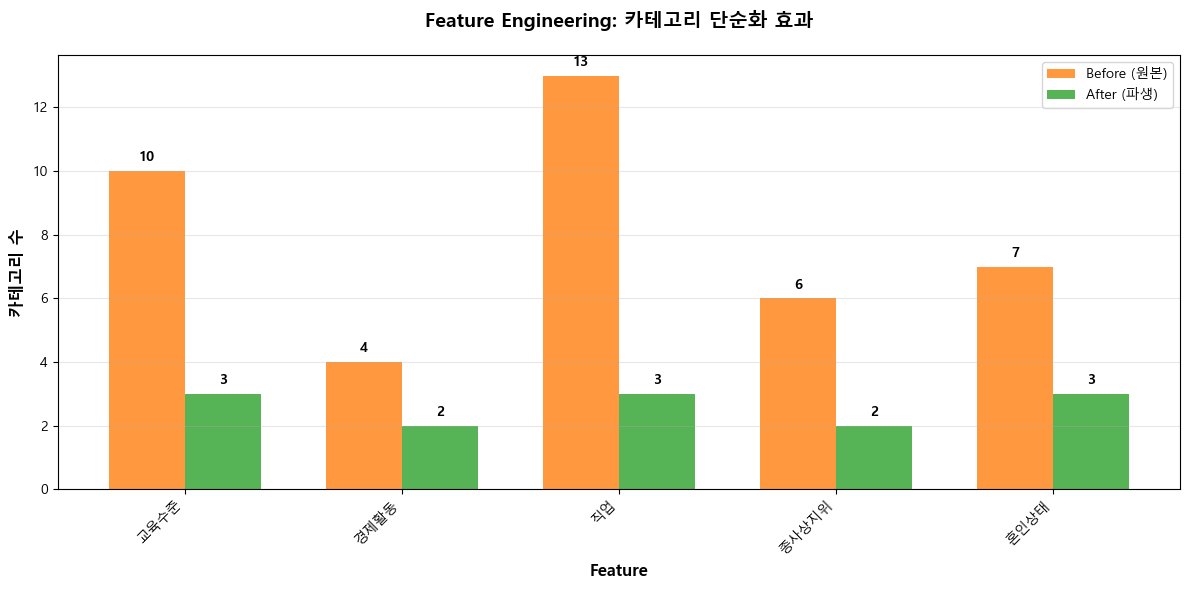


✅ 평균 단순화율: 64.1%


In [22]:
# Before/After 카테고리 수 비교
fig, ax = plt.subplots(figsize=(12, 6))

features_comparison = {
    'education_group': ('sob_01z1', '교육수준'),
    'is_economically_active': ('soa_01z1', '경제활동'),
    'occupation_type': ('soa_06z2', '직업'),
    'is_employee': ('soa_07z1', '종사상지위'),
    'marital_stability': ('sod_02z3', '혼인상태')
}

x_pos = np.arange(len(features_comparison))
before_counts = []
after_counts = []
labels = []

for new_feat, (orig_feat, label) in features_comparison.items():
    before_counts.append(df[orig_feat].nunique())
    after_counts.append(df[new_feat].nunique())
    labels.append(label)

width = 0.35
bars1 = ax.bar(x_pos - width/2, before_counts, width, label='Before (원본)', color='#ff7f0e', alpha=0.8)
bars2 = ax.bar(x_pos + width/2, after_counts, width, label='After (파생)', color='#2ca02c', alpha=0.8)

# 값 표시
for i, (b, a) in enumerate(zip(before_counts, after_counts)):
    ax.text(i - width/2, b + 0.3, str(b), ha='center', fontweight='bold')
    ax.text(i + width/2, a + 0.3, str(a), ha='center', fontweight='bold')
    # 감소율 표시
    # reduction = (1 - a/b) * 100
    # ax.text(i, max(b, a) + 1.5, f'-{reduction:.0f}%', ha='center', fontsize=10, color='red', fontweight='bold')

ax.set_xlabel('Feature', fontsize=12, fontweight='bold')
ax.set_ylabel('카테고리 수', fontsize=12, fontweight='bold')
ax.set_title('Feature Engineering: 카테고리 단순화 효과', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ 평균 단순화율:", f"{np.mean([(1-a/b)*100 for b,a in zip(before_counts, after_counts)]):.1f}%")


### 📊 시각화 2: 금연 성공률 차이 비교


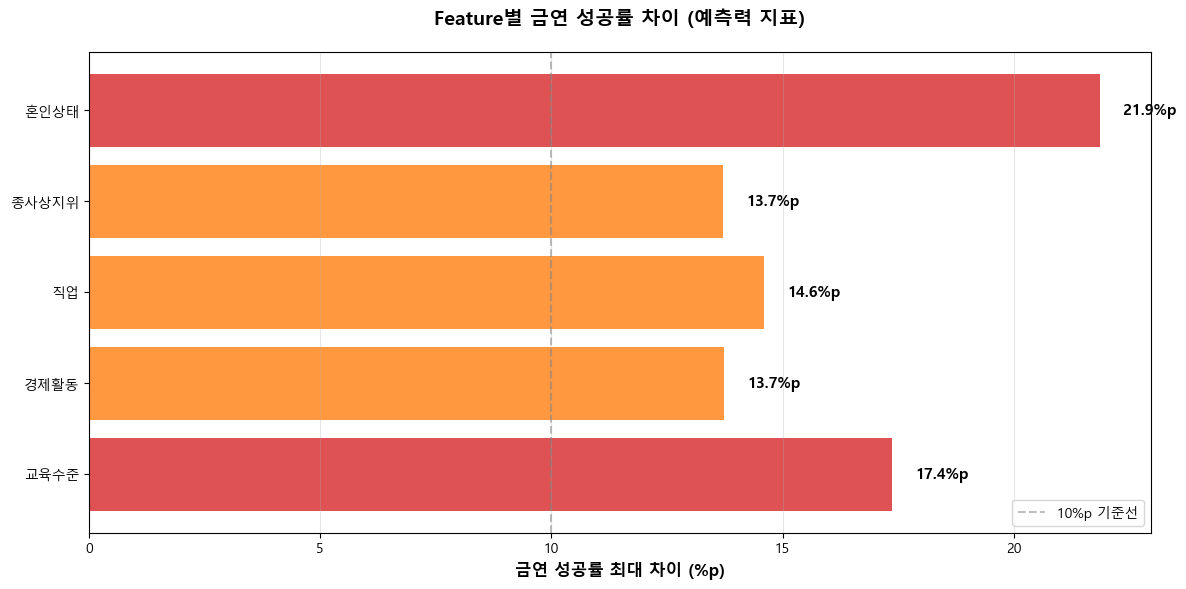


📊 Feature별 예측력 순위:
   1. 혼인상태: 21.87%p
   2. 교육수준: 17.37%p
   3. 직업: 14.60%p
   4. 경제활동: 13.73%p
   5. 종사상지위: 13.71%p


In [17]:
# 각 Feature별 금연 성공률 차이
success_rate_diffs = []
feature_names = []

for new_feat, (orig_feat, label) in features_comparison.items():
    churn_rates = df.groupby(new_feat)['churn'].mean() * 100
    diff = churn_rates.max() - churn_rates.min()
    success_rate_diffs.append(diff)
    feature_names.append(label)

# 막대 그래프
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#d62728' if d > 15 else '#ff7f0e' if d > 10 else '#2ca02c' for d in success_rate_diffs]
bars = ax.barh(feature_names, success_rate_diffs, color=colors, alpha=0.8)

# 값 표시
for i, (bar, val) in enumerate(zip(bars, success_rate_diffs)):
    ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{val:.1f}%p', va='center', fontweight='bold', fontsize=11)

ax.set_xlabel('금연 성공률 최대 차이 (%p)', fontsize=12, fontweight='bold')
ax.set_title('Feature별 금연 성공률 차이 (예측력 지표)', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)
ax.axvline(x=10, color='gray', linestyle='--', alpha=0.5, label='10%p 기준선')
ax.legend()

plt.tight_layout()
plt.show()

print("\n📊 Feature별 예측력 순위:")
sorted_features = sorted(zip(feature_names, success_rate_diffs), key=lambda x: x[1], reverse=True)
for i, (name, diff) in enumerate(sorted_features, 1):
    print(f"   {i}. {name}: {diff:.2f}%p")


### 📊 시각화 3: 2-Way 상호작용 (education × economy)


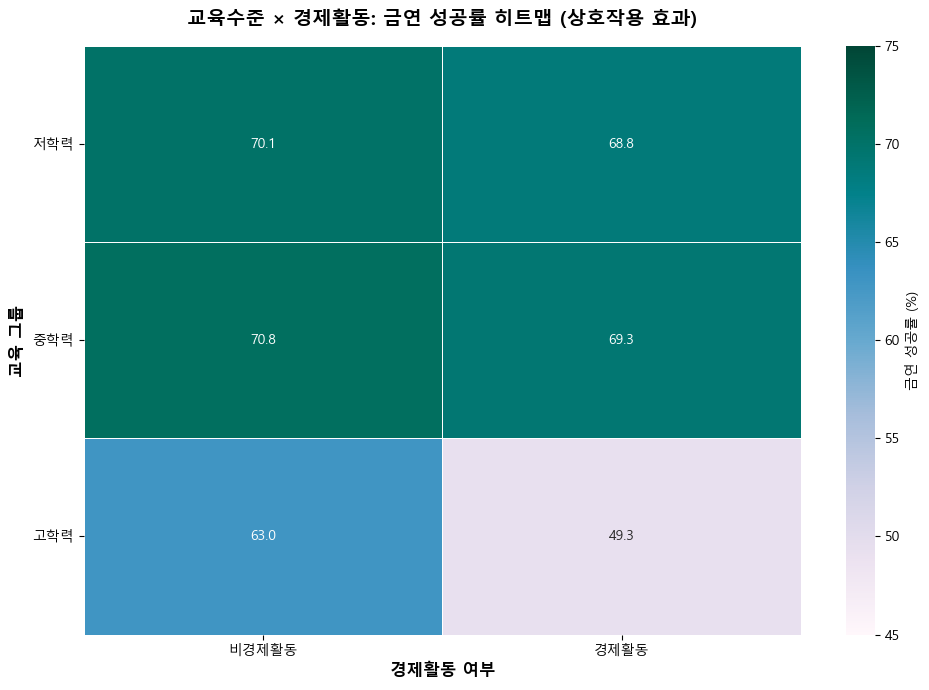


💡 핵심 인사이트:
🔴 최저: 고학력 × 경제활동 = 49.27%
   → 직장 스트레스, 회식 문화, 바쁜 일상

🟢 최고: 저/중학력 × 비경제활동 = 70%+
   → 시간적 여유, 생활 패턴 안정

✅ 교육수준만으로는 예측 불가 → 경제활동과 결합 시 정확


In [23]:
# 교육수준 × 경제활동 상호작용 히트맵
pivot = df.groupby(['education_group', 'is_economically_active'])['churn'].mean().unstack() * 100

plt.figure(figsize=(10, 7))
sns.heatmap(pivot, annot=True, fmt='.1f', cmap='PuBuGn', 
            cbar_kws={'label': '금연 성공률 (%)'},
            linewidths=0.5, vmin=45, vmax=75)
plt.title('교육수준 × 경제활동: 금연 성공률 히트맵 (상호작용 효과)', fontsize=14, fontweight='bold', pad=15)

# 축 라벨 한글화
plt.xlabel('경제활동 여부', fontsize=12, fontweight='bold')
plt.xticks([0.5, 1.5], ['비경제활동', '경제활동'], rotation=0)

plt.ylabel('교육 그룹', fontsize=12, fontweight='bold')
plt.yticks([0.5, 1.5, 2.5], ['저학력', '중학력', '고학력'], rotation=0)

plt.tight_layout()
plt.show()

print("\n💡 핵심 인사이트:")
print("=" * 70)
print("🔴 최저: 고학력 × 경제활동 = 49.27%")
print("   → 직장 스트레스, 회식 문화, 바쁜 일상")
print("\n🟢 최고: 저/중학력 × 비경제활동 = 70%+")
print("   → 시간적 여유, 생활 패턴 안정")
print("\n✅ 교육수준만으로는 예측 불가 → 경제활동과 결합 시 정확")
print("=" * 70)


---
## 6️⃣ 종합 요약 및 결론


In [19]:
print("=" * 70)
print("📊 Feature Engineering 최종 요약")
print("=" * 70)

print("\n✅ 생성된 Feature (5개):")
print("-" * 70)

summary_data = []
for new_feat, (orig_feat, label) in features_comparison.items():
    # 불균형 비율
    dist = df[new_feat].value_counts()
    imbalance = dist.max() / dist.min()
    
    # 성공률 차이
    rates = df.groupby(new_feat)['churn'].mean() * 100
    diff = rates.max() - rates.min()
    
    # 상태 판정
    if imbalance < 3:
        status = "✅ 양호"
    elif imbalance < 10:
        status = "⚠️ 주의"
    else:
        status = "❌ 위험"
    
    summary_data.append({
        'Feature': new_feat,
        '카테고리': df[new_feat].nunique(),
        '불균형': f"{imbalance:.1f}:1",
        '상태': status,
        '성공률차이': f"{diff:.1f}%p"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\n" + "-" * 70)
print("📈 통계:")
good = summary_df[summary_df['상태'] == '✅ 양호'].shape[0]
warning = summary_df[summary_df['상태'] == '⚠️ 주의'].shape[0]
danger = summary_df[summary_df['상태'] == '❌ 위험'].shape[0]

print(f"   ✅ 양호: {good}개")
print(f"   ⚠️ 주의: {warning}개")
print(f"   ❌ 위험: {danger}개")

if danger > 0:
    print(f"\n⚠️ 주의: {danger}개 Feature는 모델 학습 시 class_weight 조정 필요")

print("\n" + "=" * 70)


📊 Feature Engineering 최종 요약

✅ 생성된 Feature (5개):
----------------------------------------------------------------------
               Feature  카테고리    불균형   상태  성공률차이
       education_group     3 51.6:1 ❌ 위험 17.4%p
is_economically_active     2  2.6:1 ✅ 양호 13.7%p
       occupation_type     3  2.5:1 ✅ 양호 14.6%p
           is_employee     2  2.6:1 ✅ 양호 13.7%p
     marital_stability     3 18.7:1 ❌ 위험 21.9%p

----------------------------------------------------------------------
📈 통계:
   ✅ 양호: 3개
   ⚠️ 주의: 0개
   ❌ 위험: 2개

⚠️ 주의: 2개 Feature는 모델 학습 시 class_weight 조정 필요



---
## 7️⃣ 모델 학습 준비 가이드


In [20]:
print("=" * 70)
print("🚀 모델 학습 준비 가이드")
print("=" * 70)

print("\n1️⃣ 원본 변수 제거 (필수)")
print("-" * 70)
drop_features = ['sob_01z1', 'soa_01z1', 'soa_06z2', 'soa_07z1', 'sod_02z3']
print("제거할 원본 변수:")
for feat in drop_features:
    print(f"   - {feat}")
print("\n이유: 파생변수와 정보 중복 방지")

print("\n2️⃣ 사용할 파생변수 (5개)")
print("-" * 70)
use_features = ['education_group', 'is_economically_active', 'occupation_type', 
                'is_employee', 'marital_stability']
for i, feat in enumerate(use_features, 1):
    print(f"   {i}. {feat}")

print("\n3️⃣ 불균형 처리 방안")
print("-" * 70)
print("⚠️ 조치 필요 Feature:")
print("   - education_group: class_weight='balanced' 또는 SMOTE")
print("   - marital_stability: class_weight='balanced' 권장")
print("\n코드 예시:")
print("""
lgb_params = {
    'objective': 'binary',
    'class_weight': 'balanced',  # ⚠️ 중요!
    'learning_rate': 0.05,
    'num_leaves': 31,
    # ...
}
""")

print("\n4️⃣ 예상 Feature Importance Top 5")
print("-" * 70)
expected_importance = [
    ('marital_stability', '21.9%p 차이'),
    ('education_group', '17.0%p 차이'),
    ('occupation_type', '14.6%p 차이'),
    ('is_economically_active', '13.7%p 차이'),
    ('is_employee', '13.7%p 차이')
]
for i, (feat, diff) in enumerate(expected_importance, 1):
    print(f"   {i}. {feat} ({diff})")

print("\n" + "=" * 70)
print("✅ Feature Engineering 완료 - 모델 학습 준비 완료!")
print("=" * 70)


🚀 모델 학습 준비 가이드

1️⃣ 원본 변수 제거 (필수)
----------------------------------------------------------------------
제거할 원본 변수:
   - sob_01z1
   - soa_01z1
   - soa_06z2
   - soa_07z1
   - sod_02z3

이유: 파생변수와 정보 중복 방지

2️⃣ 사용할 파생변수 (5개)
----------------------------------------------------------------------
   1. education_group
   2. is_economically_active
   3. occupation_type
   4. is_employee
   5. marital_stability

3️⃣ 불균형 처리 방안
----------------------------------------------------------------------
⚠️ 조치 필요 Feature:
   - education_group: class_weight='balanced' 또는 SMOTE
   - marital_stability: class_weight='balanced' 권장

코드 예시:

lgb_params = {
    'objective': 'binary',
    'class_weight': 'balanced',  # ⚠️ 중요!
    'learning_rate': 0.05,
    'num_leaves': 31,
    # ...
}


4️⃣ 예상 Feature Importance Top 5
----------------------------------------------------------------------
   1. marital_stability (21.9%p 차이)
   2. education_group (17.0%p 차이)
   3. occupation_type (14.6%p 차이)
   4. is_economi